In [1]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from os import makedirs, listdir
from os.path import join
import datetime as dt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.feature_selection import r_regression, chi2, f_classif
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay


import tensorflow as tf
from tensorflow.keras import optimizers, layers, losses, regularizers 
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
%load_ext tensorboard
%matplotlib inline

In [2]:
directory = 'pcapcsv/CSE_Dataset/'
datasets = [csv_file for csv_file in listdir(directory) if csv_file.endswith('.csv')]

merged_list = []

for each_csv in datasets:
    file_path = join(directory, each_csv)
    for chunk_df1 in pd.read_csv(file_path, chunksize=10000, low_memory=False):
        chunk_df1=chunk_df1.drop(['Dst Port', 'Timestamp', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Blk Rate Avg'], axis=1)
        merged_list.append(chunk_df1)

In [3]:
combined_dataset = pd.concat(merged_list, ignore_index=True)

In [4]:
combined_dataset.info()
#del dataset["Flow Duration"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8284254 entries, 0 to 8284253
Data columns (total 71 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Protocol           object
 1   Flow Duration      object
 2   Tot Fwd Pkts       object
 3   Tot Bwd Pkts       object
 4   TotLen Fwd Pkts    object
 5   TotLen Bwd Pkts    object
 6   Fwd Pkt Len Max    object
 7   Fwd Pkt Len Min    object
 8   Fwd Pkt Len Mean   object
 9   Fwd Pkt Len Std    object
 10  Bwd Pkt Len Max    object
 11  Bwd Pkt Len Min    object
 12  Bwd Pkt Len Mean   object
 13  Bwd Pkt Len Std    object
 14  Flow Byts/s        object
 15  Flow Pkts/s        object
 16  Flow IAT Mean      object
 17  Flow IAT Std       object
 18  Flow IAT Max       object
 19  Flow IAT Min       object
 20  Fwd IAT Tot        object
 21  Fwd IAT Mean       object
 22  Fwd IAT Std        object
 23  Fwd IAT Max        object
 24  Fwd IAT Min        object
 25  Bwd IAT Tot        object
 26  Bwd IAT Mean  

In [5]:
combined_dataset.Label.value_counts()

Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Label                            59
Name: Label, dtype: int64

In [7]:
mask = combined_dataset.Label == 'Label'
combined_dataset = combined_dataset.drop(combined_dataset[mask].index)

In [8]:
combined_dataset.Label.value_counts()

Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64

In [9]:
# create a dictionary to map the values
label_map = {'Benign': 1, 'DoS attacks-Hulk': 0, 'DDOS attack-HOIC': 0, 'Infilteration': 0, 'SSH-Bruteforce': 0, 'Bot': 0, 'FTP-BruteForce': 0,
             'DoS attacks-SlowHTTPTest': 0, 'DoS attacks-Slowloris': 0, 'DoS attacks-GoldenEye': 0, 'Brute Force -XSS': 0, 
             'SQL Injection': 0, 'DDOS attack-LOIC-UDP': 0, 'Brute Force -Web': 0}

# replace the values in the label column
combined_dataset.Label = combined_dataset.Label.replace(label_map)



In [31]:
#combined_dataset = combined_dataset.drop('Label', axis=1)

In [10]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8284195 entries, 0 to 8284253
Data columns (total 71 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Protocol           object
 1   Flow Duration      object
 2   Tot Fwd Pkts       object
 3   Tot Bwd Pkts       object
 4   TotLen Fwd Pkts    object
 5   TotLen Bwd Pkts    object
 6   Fwd Pkt Len Max    object
 7   Fwd Pkt Len Min    object
 8   Fwd Pkt Len Mean   object
 9   Fwd Pkt Len Std    object
 10  Bwd Pkt Len Max    object
 11  Bwd Pkt Len Min    object
 12  Bwd Pkt Len Mean   object
 13  Bwd Pkt Len Std    object
 14  Flow Byts/s        object
 15  Flow Pkts/s        object
 16  Flow IAT Mean      object
 17  Flow IAT Std       object
 18  Flow IAT Max       object
 19  Flow IAT Min       object
 20  Fwd IAT Tot        object
 21  Fwd IAT Mean       object
 22  Fwd IAT Std        object
 23  Fwd IAT Max        object
 24  Fwd IAT Min        object
 25  Bwd IAT Tot        object
 26  Bwd IAT Mean  

In [11]:
combined_dataset=combined_dataset.drop(['Init Fwd Win Byts', 'Init Bwd Win Byts'], axis=1)

In [12]:
# create a mask that selects the rows with negative values
mask = ((combined_dataset.iloc[:,0:67]).astype(float) < 0).any(axis=1)

# use the drop method to delete the rows that match the mask
combined_dataset = combined_dataset.drop(combined_dataset[mask].index)

In [13]:
combined_dataset['Flow Byts/s'].value_counts(sort=True)

0.0               2929756
0                  115919
inf                 12163
31000000.0           8768
77000000.0           3664
                   ...   
810.9273669816          1
797.4686218354          1
812.5604934626          1
849.4117067202          1
3470.08856              1
Name: Flow Byts/s, Length: 3521224, dtype: int64

In [14]:
# print the columns with NaN values
print(combined_dataset.columns[combined_dataset.isna().any()].tolist())

['Flow Byts/s']


In [15]:
combined_dataset = combined_dataset.replace([np.inf], 0)

In [16]:
# replace nan values with 0 method to replace NaN values with zero
combined_dataset = combined_dataset.replace([np.nan], 0)

In [17]:
print(combined_dataset.columns[combined_dataset.isna().any()].tolist())

[]


In [18]:
# replace the values in the label column
label = combined_dataset['Label']

In [19]:
combined_dataset_no_l = combined_dataset.drop('Label', axis=1).astype(float)

In [20]:
combined_dataset_no_l.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8284180 entries, 0 to 8284253
Data columns (total 68 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Protocol           8284180 non-null  float64
 1   Flow Duration      8284180 non-null  float64
 2   Tot Fwd Pkts       8284180 non-null  float64
 3   Tot Bwd Pkts       8284180 non-null  float64
 4   TotLen Fwd Pkts    8284180 non-null  float64
 5   TotLen Bwd Pkts    8284180 non-null  float64
 6   Fwd Pkt Len Max    8284180 non-null  float64
 7   Fwd Pkt Len Min    8284180 non-null  float64
 8   Fwd Pkt Len Mean   8284180 non-null  float64
 9   Fwd Pkt Len Std    8284180 non-null  float64
 10  Bwd Pkt Len Max    8284180 non-null  float64
 11  Bwd Pkt Len Min    8284180 non-null  float64
 12  Bwd Pkt Len Mean   8284180 non-null  float64
 13  Bwd Pkt Len Std    8284180 non-null  float64
 14  Flow Byts/s        8284180 non-null  float64
 15  Flow Pkts/s        8284180 non-n

In [ ]:
#feature_select = f_classif(combined_dataset_no_l, label)

In [21]:
#Normalize by columns
def normalize_columns(df, cols):
    for col_name in cols:
        df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

## Sparse Autoencoder

In [22]:
combined_dataset_norm = combined_dataset.loc[combined_dataset.Label == 1]

In [23]:
combined_dataset_abnorm = combined_dataset.loc[combined_dataset.Label == 0]

In [24]:
combined_dataset_norm_y = combined_dataset_norm.Label

In [ ]:
combined_dataset_norm

In [25]:
combined_dataset_norm = combined_dataset_norm.drop('Label', axis=1).astype(float)

In [26]:
combined_dataset_norm = normalize_columns(combined_dataset_norm, combined_dataset_norm.columns.values)

In [27]:
combined_dataset_abnorm_y = combined_dataset_abnorm.Label

In [28]:
combined_dataset_abnorm = combined_dataset_abnorm.drop('Label', axis=1).astype(float)

In [29]:
combined_dataset_abnorm = normalize_columns(combined_dataset_abnorm, combined_dataset_abnorm.columns.values)

In [30]:
combined_dataset_abnorm.dtypes

Protocol           float64
Flow Duration      float64
Tot Fwd Pkts       float64
Tot Bwd Pkts       float64
TotLen Fwd Pkts    float64
                    ...   
Active Min         float64
Idle Mean          float64
Idle Std           float64
Idle Max           float64
Idle Min           float64
Length: 68, dtype: object

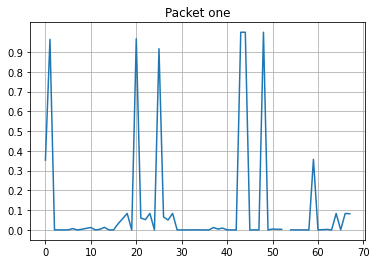

In [31]:
#fig = plt.subplots(nrows=1, ncols=2)
plt.grid()
plt.plot(np.arange(68), combined_dataset_norm.to_numpy()[172])
plt.title("Packet one")
plt.yticks([i/10 for i in range(10)])


plt.show()

In [34]:
combined_dataset_norm = combined_dataset_norm.to_numpy()
combined_dataset_abnorm = combined_dataset_abnorm.to_numpy() 

In [35]:
combined_dataset_norm = np.where(np.isnan(combined_dataset_norm), 0, combined_dataset_norm)

In [36]:
combined_dataset_abnorm = np.where(np.isnan(combined_dataset_abnorm), 0, combined_dataset_abnorm)

In [ ]:
print(np.isnan(combined_dataset_norm).any())

In [120]:
class SparseAEAnomalyDetector(Model):
    def __init__(self):
        super(SparseAEAnomalyDetector, self).__init__()
        self.encoder = layers.Dense(68, activation="relu", activity_regularizer=regularizers.l1(10e-5))

        self.decoder = layers.Dense(68, activation="sigmoid")
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = SparseAEAnomalyDetector()

In [122]:
autoencoder.compile(optimizer='adam', loss='mae')#, metrics=['accuracy'])
#Strop training when overfitting is detected
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                  patience=5, 
                                                  #min_delta=0.001, 
                                                  #mode='auto', 
                                                  verbose=2, 
                                                  baseline=None, 
                                                  restore_best_weights=True)

logdir = join("logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)


In [123]:
history = autoencoder.fit(combined_dataset_norm, combined_dataset_norm,
          epochs=50, 
          batch_size=256,
          validation_data=(combined_dataset_abnorm, combined_dataset_abnorm),
          shuffle=True,
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/50
23876/23876 [==============================] - 164s 7ms/step - loss: 0.0076 - val_loss: 0.0158
Epoch 2/50
23876/23876 [==============================] - 168s 7ms/step - loss: 0.0032 - val_loss: 0.0154
Epoch 3/50
23876/23876 [==============================] - 174s 7ms/step - loss: 0.0031 - val_loss: 0.0147
Epoch 4/50
23876/23876 [==============================] - 170s 7ms/step - loss: 0.0030 - val_loss: 0.0160
Epoch 5/50
23876/23876 [==============================] - 173s 7ms/step - loss: 0.0030 - val_loss: 0.0177
Epoch 6/50
23876/23876 [==============================] - 168s 7ms/step - loss: 0.0029 - val_loss: 0.0185
Epoch 7/50
23876/23876 [==============================] - 166s 7ms/step - loss: 0.0029 - val_loss: 0.0181
Epoch 8/50
23876/23876 [==============================] - 171s 7ms/step - loss: 0.0029 - val_loss: 0.0164
Epoch 9/50
23876/23876 [==============================] - 167s 7ms/step - loss: 0.0025 - val_loss: 0.0157
Epoch 10/50
23876/23876 [=====================

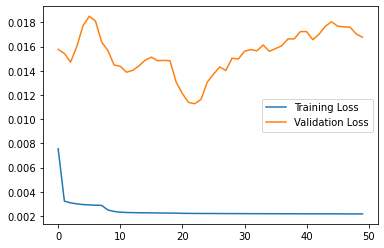

In [124]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.savefig('Training_Loss_SA_Sup_AD.png')

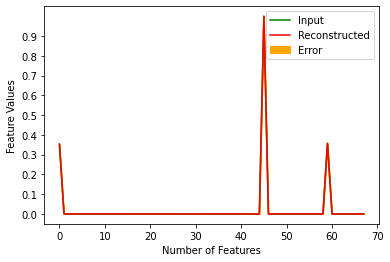

In [127]:
encoded_data = autoencoder.encoder(combined_dataset_norm).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(combined_dataset_norm[12], 'g')
plt.plot(decoded_data[12], 'r')
plt.fill_between(np.arange(68), decoded_data[12], combined_dataset_norm[12], color='orange')
plt.legend(labels=["Input", "Reconstructed", "Error"])
plt.ylabel('Feature Values')
plt.xlabel('Number of Features')
plt.yticks([i/10 for i in range(10)])
plt.savefig("rec_0.png")
plt.show()

In [126]:
tf.saved_model.save(autoencoder, 'tensormodel/Sparse_Autoencoder_Model')

INFO:tensorflow:Assets written to: tensormodel/Sparse_Autoencoder_Model\assets


In [74]:
reconstructions = autoencoder.predict(combined_dataset_abnorm)
train_loss = tf.keras.losses.mse(reconstructions, combined_dataset_norm)

191005/191005 [==============================] - 191s 1ms/step


C:\Users\Kasutaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


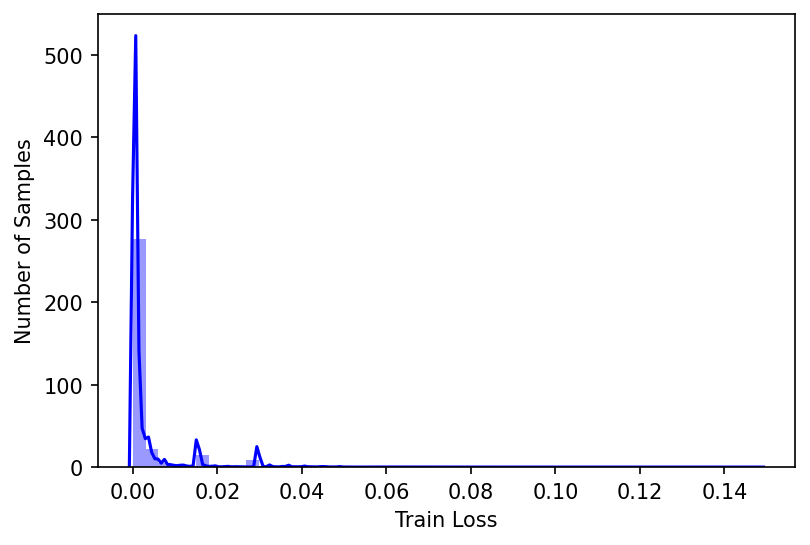

In [128]:
# Plot the histogram using seaborn
plt.subplots(dpi=150)

dist_sns = sns.distplot(train_loss[None,:], color="b")

plt.xlabel("Train Loss")
plt.ylabel("Number of Samples")
plt.savefig("sns_distri.png")

In [129]:
# Compute the median and MAD of the reconstruction error
b = 1.4826
median = np.median(train_loss)
mad = b * np.median(np.abs(train_loss - median))

# Set the threshold based on the median and MAD
k = 3
threshold_median = median + k * mad

print("Threshold median:", threshold_median) 

Threshold median: 0.001900743460345759


In [130]:
threshold_std =  np.mean(train_loss) + np.std(train_loss)
print("Threshold std:", threshold_std) 

Threshold std: 0.010431372708529429


In [131]:
#Threshold using Percentile
l_0, l_1  =  label.value_counts()
threshold_perc = (l_1/(l_1 + l_0))
print("Threshold percentile:", threshold_perc)

Threshold percentile: 0.262191792066324


In [136]:
#reconstructions = autoencoder.predict(combined_dataset_abnorm)
#test_loss = tf.keras.losses.mse(reconstructions, combined_dataset_abnorm)

191005/191005 [==============================] - 246s 1ms/step


In [137]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return reconstructions, loss, tf.math.less(loss, threshold) #Returns the truth value of (loss < threshold) element-wise.

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [138]:
model, rec_loss, pred_ = predict(autoencoder, combined_dataset_abnorm,  threshold_median)

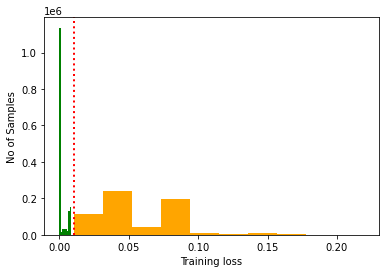

In [139]:
a=np.array(rec_loss[None,:])

anomaly = a[a >= threshold_std]
normal =  a[a < threshold_std]

plt.hist(normal, color='g')
plt.hist(anomaly, color='orange')
plt.xlabel("Training loss")
plt.ylabel("No of Samples")

plt.axvline(threshold_std, color='red', linestyle='dotted', linewidth=2)
plt.savefig("Anomaly Sample STD.png")
plt.show()

In [140]:
print_stats(pred_, combined_dataset_abnorm_y.astype(bool))

Accuracy = 0.4719379533747935
Precision = 0.0
Recall = 0.0


C:\Users\Kasutaja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


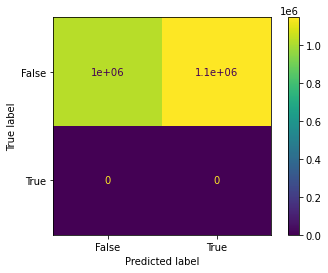

In [141]:
ConfusionMatrixDisplay.from_predictions(combined_dataset_abnorm_y.astype(bool), pred_)
plt.show()

## Isolation Forest

In [142]:
train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(
    combined_dataset_no_l, label, test_size=0.5, random_state=42
)

In [143]:
l_0, l_1 = label.value_counts()

In [144]:
label.value_counts()

1    6112136
0    2172044
Name: Label, dtype: int64

In [145]:
cont = (l_1 / (l_1 + l_0))

contamination = round(cont, 1)


In [146]:
train_data_x = train_data_x.replace([np.inf], 0)

In [147]:
test_data_x = test_data_x.replace([np.inf], 0)

In [175]:
#train_data_x = train_data_x.fillna(0)

In [176]:
# create a mask that selects the rows with negative values
#mask = ((train_data_x).astype(float) < 0).any(axis=1)

# use the drop method to delete the rows that match the mask
#train_data_x = train_data_x.drop(train_data_x[mask].index)

In [177]:
#train_data_x.info()

In [148]:
iso_forest = IsolationForest(contamination=contamination,random_state=0, n_estimators=250, max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=None, verbose=0, warm_start=False)
iso_forest.fit(train_data_x)

IsolationForest(contamination=0.3, n_estimators=250, random_state=0)

In [149]:
iso_predict = iso_forest.predict(test_data_x)

In [150]:
empty_df_iso = pd.DataFrame()

In [151]:
empty_df_iso['scores']=iso_forest.decision_function(test_data_x)

In [152]:
empty_df_iso['iso_f_label'] = iso_predict
#outliers = empty_df.loc[empty_df['iso_f_label'] == -1]
#outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
benign, anomalous = empty_df_iso['iso_f_label'].value_counts()

In [153]:
target_names= ['benign', 'anomalous']

In [154]:
# create a dictionary to map the values
label_map = {1: 0, -1:1}

# replace the values in the label column
empty_df_iso.iso_f_label = empty_df_iso.iso_f_label.replace(label_map)


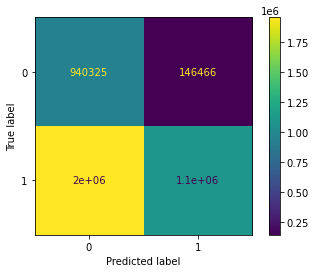

In [155]:
ConfusionMatrixDisplay.from_predictions(test_data_y.to_numpy(), empty_df_iso.iso_f_label.to_numpy())
plt.show()

In [156]:
print(classification_report(test_data_y.to_numpy(), empty_df_iso.iso_f_label.to_numpy(), target_names=target_names))

              precision    recall  f1-score   support

      benign       0.32      0.87      0.47   1086791
   anomalous       0.88      0.36      0.51   3055299

    accuracy                           0.49   4142090
   macro avg       0.60      0.61      0.49   4142090
weighted avg       0.74      0.49      0.50   4142090



## Local outlier Factor

In [157]:
lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=contamination, novelty=False)

In [158]:
test_data_x = normalize_columns(test_data_x, test_data_x.columns.values)

In [159]:
test_data_x = test_data_x.replace([np.nan], 0)

In [ ]:
#lof_fit = lof.fit(train_data_norm)
#n_errors = (y_pred != ground_truth).sum()
lof_pred=lof.fit_predict(test_data_x)

In [ ]:
lof_scores = lof.negative_outlier_factor_

In [ ]:
empty_df_lof = pd.DataFrame()
empty_df_lof['lof_label'] = lof_pred
empty_df_lof['lof_score'] = lof_scores
#outliers = empty_df.loc[empty_df['iso_f_label'] == -1]
#outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(empty_df_lof['lof_label'].value_counts())

In [ ]:
# replace the values in the label column
empty_df_lof.lof_label = empty_df_lof.lof_label.replace(label_map)

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_data_y.to_numpy(), empty_df_lof.lof_label.to_numpy())
plt.show()